## Exercise 3: Using the Titanic dataset, train a classifier to predict the survived column

In [11]:
# Import data from the Titanic dataset, downloaded from Kaggle.
# The dataset is split into train and test sets, with the test set not containing the survival column
import pandas as pd

# Load data from CSV files
train = pd.read_csv("./datasets/titanic/train.csv")
test = pd.read_csv("./datasets/titanic/test.csv")
target = pd.read_csv("./datasets/titanic/gender_submission.csv")



### Data exploration / cleaning

In [12]:
# Data exploration

# I  checked distributions and number of missing values in the dataset using datawrangler in VS Code.
# Various columns have skewed distributions, such as Fare.
# Cabin is mostly missing (>70%), so might be a good idea to drop it.
# Age has some missing values (20%), may be an important factor for survival rate, so we will impute it.


# Lets drop the passanger name and ticket as it is not useful for our analysis.
train.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)

# After further investigation, I found that Cabin has letters which indicates the deck the passenger room was on, which might be useful for survival analysis.
# This is based on the assumption that higher decks had better chances of survival as their closer to the lifeboats and that the lower decks were flooded first.
# Decks according to wikipedia are A, B, C, D, E, F, G, T (the observation deck).
# So I will extract the furthest letter (max based on alphabet) from the Cabin column, with missing values filled with 'U' for unknown.
train['Cabin'] = train['Cabin'].fillna('U').astype(str).apply(lambda x: max(x) if x != 'U' else 'U')

# Check counts in each cabin category
print(train['Cabin'].value_counts())

# There's an odd value 'T', which with further research, it turns out was a cabin was on the boat deck (above A),
# however, since it's only 1 value and insufficent N to be statistically relevant, I will convert it to it's nearest deck A instead
train['Cabin'].replace('T', 'A', inplace=True)

# Check counts in each cabin again category
print(train['Cabin'].value_counts())


Cabin
U    687
C     59
B     47
D     33
E     32
A     15
F     10
G      7
T      1
Name: count, dtype: int64
Cabin
U    687
C     59
B     47
D     33
E     32
A     16
F     10
G      7
Name: count, dtype: int64


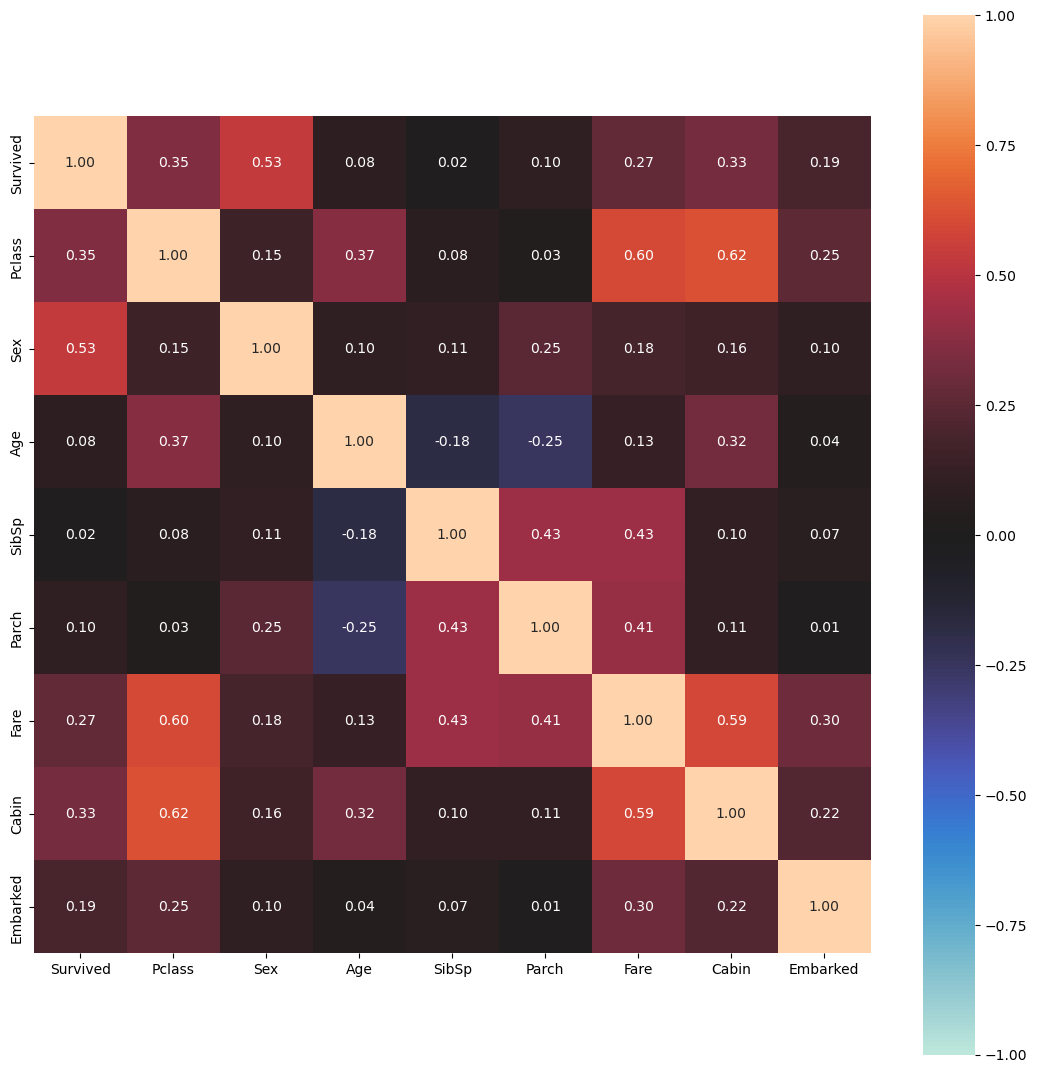

{'corr':           Survived    Pclass       Sex       Age     SibSp     Parch  \
 Survived  1.000000  0.353957  0.532843  0.082446  0.015523  0.095265   
 Pclass    0.353957  1.000000  0.150396  0.369439  0.077834  0.027969   
 Sex       0.532843  0.150396  1.000000  0.099037  0.106296  0.249543   
 Age       0.082446  0.369439  0.099037  1.000000 -0.180426 -0.253183   
 SibSp     0.015523  0.077834  0.106296 -0.180426  1.000000  0.426322   
 Parch     0.095265  0.027969  0.249543 -0.253183  0.426322  1.000000   
 Fare      0.266100  0.600105  0.182457  0.130632  0.427503  0.411009   
 Cabin     0.327834  0.624993  0.163661  0.318302  0.103941  0.105024   
 Embarked  0.190919  0.250598  0.096588  0.042340  0.066014  0.014083   
 
               Fare     Cabin  Embarked  
 Survived  0.266100  0.327834  0.190919  
 Pclass    0.600105  0.624993  0.250598  
 Sex       0.182457  0.163661  0.096588  
 Age       0.130632  0.318302  0.042340  
 SibSp     0.427503  0.103941  0.066014  
 Parch  

In [13]:
### Look at associations between categorical and numerical variables using dython package
# cat - cat uses Cramer's V
# num - num uses Spearman correlation
# cat - num uses correlation ratio
# Na's are handled by removing rows with NaNs


from dython.nominal import associations
associations(train,
             nominal_columns=["Survived", "Pclass", "Sex", "Embarked", "Cabin"],
             numerical_columns=["Age", "SibSp", "Parch", "Fare"],
             num_num_assoc="spearman", nan_strategy="drop_samples",  plot=True)

### Observations:
# Pclass seems to be highly associated with both Cabin and Fare, which makes sense. Might introduce multicollinearity in some models if all included.
# Sex is highly associated with survival, which makes sense given historical context.
# 2nd, 3rd and 4th highest association = Pclass then Cabin, followed by Fare.
# Age has a low association with survival, but it is still worth including in the model.
# Age is correlated with Pclass, parch, SibSp and Fare, however only moderately at best, can effect what method of imputation to use.


In [14]:
# Check missing values in all columns
print(train.isnull().sum())

# Since only 2 missing value in Embarked, will just fill it with the most common value
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin         0
Embarked      2
dtype: int64


In [15]:
# We need to encode all categorical variables before using KNN imputer
print(train.dtypes)

# Need to convert Pclass to object first, otherwise OrdinalEncoder will treat it as numerical
train['Pclass'] = train['Pclass'].astype(object)

# Specify value order
ord_cats = ["Cabin", "Pclass"]
ord_levels = [['U', 'G', 'F', 'E', 'D', 'C', 'B', 'A'], [3, 2, 1]]

# Ordinal encode the ordinal categorical variables
from sklearn.preprocessing import OrdinalEncoder
ord_encoder = OrdinalEncoder(categories=ord_levels, dtype=int, handle_unknown='use_encoded_value', unknown_value=-1)
train[ord_cats] = ord_encoder.fit_transform(train[ord_cats])


# We OneHot encode the categorical variables before using KNN imputer
from sklearn.preprocessing import OneHotEncoder

# Specify nominal categorical columns
nom_cat = ["Embarked", "Sex"]

# OneHot encode the nominal categorical variables
OH_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_OH = pd.DataFrame(OH_encoder.fit_transform(train[nom_cat]), columns=OH_encoder.get_feature_names_out(nom_cat))
# Concat the OneHot encoded columns back to the original dataframe and drop the original nominal categorical columns
train = pd.concat([train, train_OH], axis=1)

# Drop the original nominal categorical columns
train.drop(columns=nom_cat, inplace=True)

# Check dtypes again
print(train.dtypes)



Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Cabin        object
Embarked     object
dtype: object
Survived        int64
Pclass          int32
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Cabin           int32
Embarked_C    float64
Embarked_Q    float64
Embarked_S    float64
Sex_female    float64
Sex_male      float64
dtype: object


In [16]:
# Imputation of Age using KNN imputer from sklearn
# Due to Age not having strong correlation with other variables, best not to use regression imputation.
# KNN imputer can be a good choice as it can handle non-linear relationships and is not affected by outliers.

from sklearn.impute import KNNImputer

# Will use correlation >0.1: Cabin, Pclass, SibSp, Parch, Fare for imputation.
features_for_imputation = ['Age', 'Cabin', 'Pclass', 'SibSp', 'Parch', 'Fare']

# Subset dataframe
train_subset = train[features_for_imputation]

# Apply KNN imputer
imputer = KNNImputer(n_neighbors=5)
train_imputed = imputer.fit_transform(train_subset)

# Put the imputed values back into the original dataframe
train["Age"] = train_imputed[:, 0]


## Model selection
We need to test different models to see which works best for predicting survival. We should limit these to models that make the most sense for the dataset. Many of the variables such as Fare, Pclass and Cabin are highly correlated, so tree-based methods, and regularised regression/SVMs would be a good choice.

In [17]:

# Import classifers and model selection methods
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Use all available cores except 2 to avoid overloading the system
cores = os.cpu_count()-2

# Random forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=os.cpu_count()-2) 
rf_scores = cross_val_score(rf_clf, train.drop(columns=['Survived']), train['Survived'], cv=5, scoring='accuracy', n_jobs=cores)
print(f"Random Forest Classifier Accuracy: {rf_scores.mean():.4f} (+/- {rf_scores.std():.4f})")



Random Forest Classifier Accuracy: 0.8070 (+/- 0.0334)


In [18]:
# XGBoost classifier
import xgboost as xgb

# XGB classifier
xgb_clf = xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=cores) #, use_label_encoder=False, eval_metric='logloss'
xgb_scores = cross_val_score(xgb_clf, train.drop(columns=['Survived']), train['Survived'], cv=5, scoring='accuracy', n_jobs=cores)
print(f"XGBoost Classifier Accuracy: {xgb_scores.mean():.4f} (+/- {xgb_scores.std():.4f})")


XGBoost Classifier Accuracy: 0.8171 (+/- 0.0252)


In [19]:
from sklearn.svm import SVC

# SVM classifier
svm_clf = SVC(kernel='rbf', C=1, gamma='scale', random_state=42) 
svm_scores = cross_val_score(svm_clf, train.drop(columns=['Survived']), train['Survived'], cv=5, scoring='accuracy', n_jobs=cores)
print(f"SVM Classifier Accuracy: {svm_scores.mean():.4f} (+/- {svm_scores.std():.4f})")


SVM Classifier Accuracy: 0.6690 (+/- 0.0407)


So from the above quick tests, we can see that both Random Forest and XGBoost would work well. Since XGBoost got the highest score with the smallest SD, we will tune the hyperparameters for it.

In [20]:
# Load libs for hyperparameter tuning
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter tuning for XGBoost using RandomizedSearchCV, this is more efficeint than GridSearchCV for large hyperparameter spaces.
# Define the parameter grid
params = {
    'max_depth': randint(1,10),
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(50, 1000),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}

# Initialize the XGBClassifier
xgb_clf = xgb.XGBClassifier(random_state=42, n_jobs=cores)

# Initialize RandomizedSearchCV
rand_search = RandomizedSearchCV(xgb_clf, param_distributions=params, n_iter=1000, scoring='accuracy', cv=5, n_jobs=cores, random_state=42)
rand_search.fit(train.drop(columns=['Survived']), train['Survived'])

# Output the best parameters and the corresponding score
print(f"Best parameters: {rand_search.best_params_}")
print(f"Best cross-validation accuracy: {rand_search.best_score_:.4f}")


Best parameters: {'colsample_bytree': 0.6063221881855481, 'learning_rate': 0.019956806368727868, 'max_depth': 5, 'n_estimators': 998, 'subsample': 0.8265813952656416}
Best cross-validation accuracy: 0.8440


Text(0, 0.5, 'Feature')

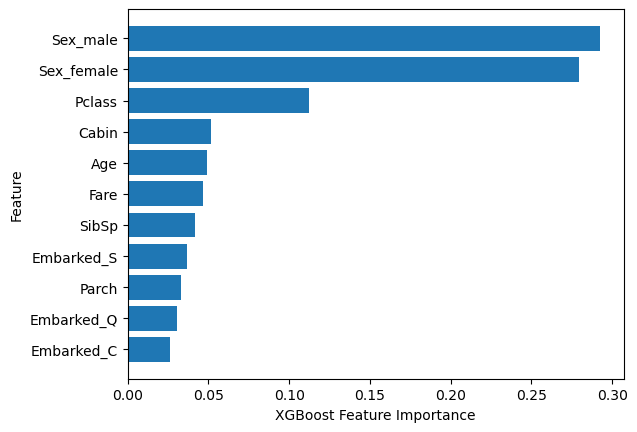

In [23]:
# Identify the most important features from the tuned XGBoost model
xgb_clf_tuned = xgb.XGBClassifier(**rand_search.best_params_, random_state=42, n_jobs=cores)
xgb_clf_tuned.fit(train.drop(columns=['Survived']), train['Survived'])

sorted_index = xgb_clf_tuned.feature_importances_.argsort()

import matplotlib.pyplot as plt
plt.barh(train.drop(columns=['Survived']).columns[sorted_index], xgb_clf_tuned.feature_importances_[sorted_index])
plt.xlabel("XGBoost Feature Importance")
plt.ylabel("Feature")

In [ ]:
# Check cross validated AUC score using the tuned hyperparameters
cv_results = xgb.cv(
    params=rand_search.best_params_,
    dtrain=xgb.DMatrix(train.drop(columns=['Survived']), label=train['Survived']),
    num_boost_round=1000,
    nfold=5,
    metrics="auc",
    early_stopping_rounds=10,
    as_pandas=True,
    seed=42
)

print(cv_results.tail())
print("Best AUC:", cv_results['test-auc-mean'].max())

[13:53:35] WARNING: D:\bld\xgboost-split_1700182179651\work\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[13:53:35] WARNING: D:\bld\xgboost-split_1700182179651\work\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[13:53:35] WARNING: D:\bld\xgboost-split_1700182179651\work\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[13:53:35] WARNING: D:\bld\xgboost-split_1700182179651\work\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[13:53:35] WARNING: D:\bld\xgboost-split_1700182179651\work\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
19        0.916355       0.004107       0.866175      0.029607
20        0.917072       0.003716       0.866432      0.030352
21        0.917814       0.002814       0.867901      0.030066
22        0.917610       0.002818       0.867935      0.030309
23        0.917969       0.002970       0.868359  

In [24]:
test2 = test.copy()

In [39]:
test = test2.copy()

## Applying final model to test set

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

# First need to treat test set the same way as the training set
# Drop unnecessary columns
test.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)

# Test doesn't have embarked missing values, so no need to fill

# Fare is missing 1 value, so fill it with the median fare
test['Fare'].fillna(test['Fare'].median(), inplace=True)

# Ordinal encode Cabin and Pclass
test['Cabin'] = test['Cabin'].fillna('U').astype(str).apply(lambda x: max(x) if x != 'U' else 'U')
test['Cabin'].replace('T', 'A', inplace=True)
test['Pclass'] = test['Pclass'].astype(object)
test[ord_cats] = ord_encoder.transform(test[ord_cats])

# OneHot encode nominal categorical variables
test_OH = pd.DataFrame(OH_encoder.fit_transform(test[nom_cat]), columns=OH_encoder.get_feature_names_out(nom_cat))
test = pd.concat([test, test_OH], axis=1)
test.drop(columns=nom_cat, inplace=True)


# KNN impute Age
test_subset = test[features_for_imputation]
test_imputed = imputer.fit_transform(test_subset)
test["Age"] = test_imputed[:, 0]


# Predict survival and probability on the test set using the tuned XGBoost model
predictions = xgb_clf_tuned.predict(test)
proba = xgb_clf_tuned.predict_proba(test)[:, 1]


# Evaluate scores
print("Accuracy:", accuracy_score(target['Survived'], predictions))
print("AUC:", roc_auc_score(target['Survived'], proba))




Accuracy: 0.861244019138756
AUC: 0.9097002374356945


Not bad, there's some evidence from the cross-validation that there is mild overfitting, but when examined on the test set, the AUC was 0.91 meaning it is likely to generalise well (hopefully not to future titanic incidents).